# Project 2 - Autonomous Driving

By Laura Madrid & Lucas Noritomi-Hartwig

Autonomous driving is one of the major research venues these days. A lot of 
effort is devoted to it by both the academics as well as industry. In this 
project you'll familiarize yourself with some of the most important problems 
that arise in the field of autonomous driving.

The input to your algorithm is a stereo image pair and the camera parameters. 
You will also have available a set of training images where the cars have been 
annotated with 2D bounding boxes as well as viewpoint. Furthermore, you'll have 
a few images where the road has been annotated. Here are the tasks to solve:

### 1. Compute disparity between the two stereo images. We do not mind if you use existing code as long as you include a description of the algorithm you used, showing you understand what it is doing.

### 2. Compute depth of each pixel. Compute 3D location of each pixel.

In [57]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from skimage import io

In [58]:
# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        img_path = os.path.join(directory, filename)
        # Avoiding ".DS_store" file that may or may not appear in directory
        if os.path.isfile(img_path) and not filename.startswith('.'):
            try:
                img = io.imread(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return images

In [59]:
def convert_to_grayscale(images):
    return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

In [60]:
# Path to the directories containing the images
LEFT_IMAGE_DIR = "project2/train/image_left"
RIGHT_IMAGE_DIR = "project2/train/image_right"
GROUND_TRUTH_DIR = "project2/train/gt_image_left"
num_images = 134

# Load left images
left_images = load_images_from_directory(LEFT_IMAGE_DIR)
left_images_gray = convert_to_grayscale(left_images)
assert(len(left_images) == num_images)

# Load right images
right_images = load_images_from_directory(RIGHT_IMAGE_DIR)
right_images_gray = convert_to_grayscale(right_images)
assert(len(right_images) == num_images)

# Load ground truth images
ground_truth_images = load_images_from_directory(GROUND_TRUTH_DIR)
assert(len(ground_truth_images) == num_images)

In [61]:
# Camera parameters
FOCAL_LENGTH = 7.215377000000e+02  # milimetres (from files in calib folders)
PX, PY = 6.095593000000e+02, 1.728540000000e+02  # from files in calib folders
BASELINE = 54  # 54 centimetres from https://www.cvlibs.net/datasets/kitti/

In [62]:
def sum_of_square_diff(left_image_patch, right_image_patch) -> float:
    """
    Calculate the sum of squared differences between individual pixels.
    
    Args:
        left_image_patch (numpy.ndarray): Pixel block from left image.
        right_image_patch (numpy.ndarray): Pixel block from right image.
        
    Returns:
        float: Sum of absolute differences between the two pixel blocks.
    """
    # Check that images are of the same shape.
    if left_image_patch.shape != right_image_patch.shape:
        return -1

    return np.sum(np.square(left_image_patch - right_image_patch))

In [63]:
def compare_blocks(y, x, left_block, right_image, block_size=5, 
                   search_range=25):
    """
    Compare a block from the left image with blocks in the right image along the
    same horizonatl line to find the best match.
    
    Args:
        y (int): Row index of the left block.
        x (int): Column index of the left block.
        left_block (numpy.ndarray): Pixel block from the left image.
        right_image (numpy.ndarray): Entire right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        tuple: (y, x) indices of the best matching block in the right image.
    """
    # Define upper bound of search range in the right image.
    x_min = max(0, x - search_range)
    x_max = min(right_image.shape[1], x + block_size)

    # Initialize the minimum sum of squared differences (SSD) and its index.
    min_ssd, index_of_min_ssd = float("inf"), None

    # Iterate over the search range in the right image.
    y_p_block_size = y + block_size
    for x in range(x_min, x_max):
        right_block = right_image[y:y_p_block_size, x:x + block_size]
        ssd = sum_of_square_diff(left_block, right_block)

        # Update the min sum of squared differences and its index accordingly.
        if ssd < min_ssd:
            min_ssd, index_of_min_ssd = ssd, (y, x)

    return index_of_min_ssd

In [64]:
def normalize_map(map):
    map = (map - np.min(map))
    return map / np.max(map)

In [65]:
def calculate_disparity_and_depth_map(left_image, right_image, block_size=5, 
                                      search_range=8):
    """
    Calculate the disparity map between two images using block matching.

    Args:
        left_image (numpy.ndarray): Left image.
        right_image (numpy.ndarray): Right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        disparity_map (numpy.ndarray): Disparity map.
        depth_map (numpy.ndarray): Depth map.
    """
    h, w = left_image.shape
    disparity_map = np.zeros((h, w))

    # Iterate over the entire image except for the borders
    h_m_block_size, w_m_block_size = h - block_size, w - block_size
    for y in tqdm(range(block_size, h_m_block_size)):
        y_p_block_size = y + block_size
        for x in range(block_size, w_m_block_size):
            left_block = left_image[y:y_p_block_size, x:x + block_size]
            min_index = compare_blocks(y, x, left_block, right_image,
                                       block_size, search_range)
            # Compute pixel disparity
            disparity_map[y, x] = abs(min_index[1] - x)

    # return disparity_map
    return normalize_map(disparity_map)

In [66]:
def calculate_disparity_and_depth_map_cv2(left_image, right_image, block_size=5, 
                                          search_range=8):
    """
    Calculate the disparity map between two images using block matching.

    Args:
        left_image (numpy.ndarray): Left image.
        right_image (numpy.ndarray): Right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        disparity_map (numpy.ndarray): Disparity map.
        depth_map (numpy.ndarray): Depth map.
    """

    # Initialize the StereoSGBM object
    stereo = cv2.StereoSGBM_create(minDisparity=0,
                                   numDisparities=16 * search_range,
                                   blockSize=block_size,
                                   uniquenessRatio=10,
                                   speckleWindowSize=100,
                                   speckleRange=32,
                                   disp12MaxDiff=1,
                                   P1=8 * 3 * block_size ** 2,
                                   P2=32 * 3 * block_size ** 2)

    # Compute disparity
    disparity_map = stereo.compute(left_image, right_image)

    # return disparity_map
    return normalize_map(disparity_map)

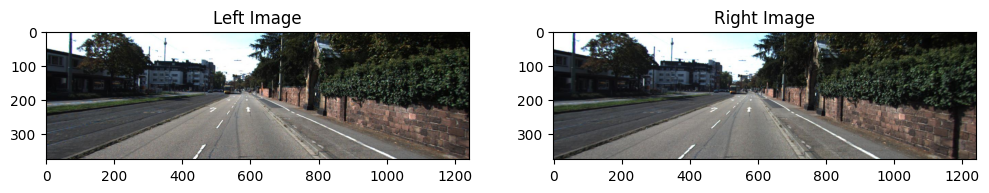

In [67]:
# Load sample images
left_image = left_images[0]
right_image = right_images[0]

plt.figure(figsize=(12, 6))

# Plot the left image in the first subplot
plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
plt.imshow(left_image)
plt.title("Left Image")
plt.grid(False)

# Plot the right image in the first subplot
plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
plt.imshow(right_image)
plt.title("Right Image")
plt.grid(False)

# Display the plot
plt.show()

left_image_gray = left_images_gray[0]
right_image_gray = right_images_gray[0]

100%|██████████| 365/365 [01:39<00:00,  3.66it/s]
/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_52805/2452112810.py:14: RuntimeWarning: divide by zero encountered in divide
  depth_map = (FOCAL_LENGTH * BASELINE) / disparity_map


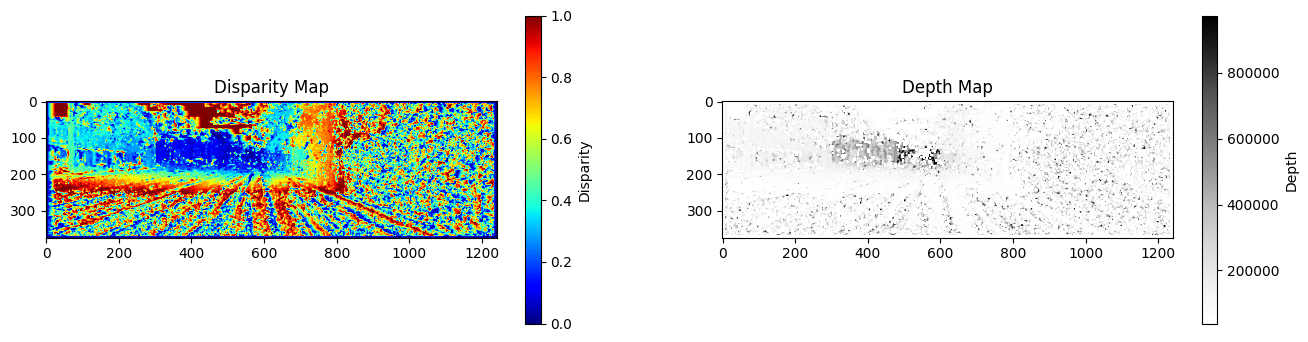

In [68]:
show_dis_dep = True
if show_dis_dep:
    # Set block size and search range
    block_size = 5
    search_range = 25

    # Compute disparity and depth map
    disparity_map = calculate_disparity_and_depth_map(left_image_gray, 
                                                    right_image_gray, 
                                                    block_size, 
                                                    search_range)

    # Compute depth map
    depth_map = (FOCAL_LENGTH * BASELINE) / disparity_map

    # Set figure size
    plt.figure(figsize=(16, 4))

    # Visualize the computed disparity map
    plt.subplot(1, 2, 1)
    plt.imshow(disparity_map, cmap="jet")
    plt.colorbar(label='Disparity')
    plt.title("Disparity Map")
    plt.grid(False)

    # Visualize the computed depth map
    plt.subplot(1, 2, 2)
    plt.imshow(depth_map, cmap="Greys")
    plt.colorbar(label='Depth')
    plt.title("Depth Map")
    plt.grid(False)

    # Display the plot
    plt.show()

/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_52805/3612186489.py:13: RuntimeWarning: divide by zero encountered in divide
  depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / disparity_map_cv2


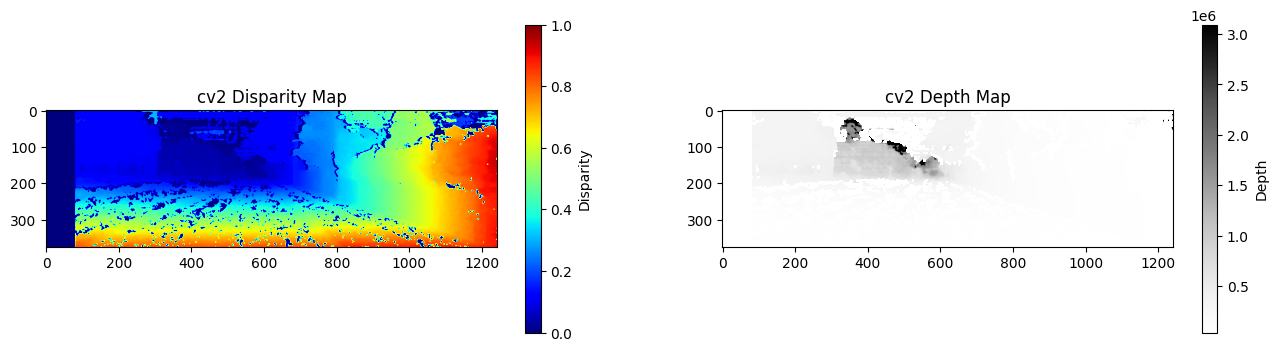

In [69]:
# Set block size and search range
block_size = 5
search_range = 5

# Compute disparity map by cv2
disparity_map_cv2 = calculate_disparity_and_depth_map_cv2(left_image_gray, 
                                                          right_image_gray, 
                                                          block_size, 
                                                          search_range)

# Compute depth map
# depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map_cv2))
depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / disparity_map_cv2

# Set figure size
plt.figure(figsize=(16, 4))

# Visualize the computed disparity map
plt.subplot(1, 2, 1)
plt.imshow(disparity_map_cv2, cmap="jet")
plt.colorbar(label='Disparity')
plt.title("cv2 Disparity Map")
plt.grid(False)

# Visualize the computed depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_map_cv2, cmap="Greys")
plt.colorbar(label='Depth')
plt.title("cv2 Depth Map")
plt.grid(False)

# Display the plot
plt.show()

In [70]:
def compute_3D_location(depth_map):
    """
    Compute the 3D locations of the pixels for a given image using its 
    depth_map.
    """
    # Create xy-coordinate matrix
    y_size, x_size = depth_map.shape
    range_x, range_y = np.arange(0, x_size), np.arange(0, y_size)
    axis_x = np.repeat(range_x[np.newaxis, ...], len(range_y), axis=0)
    axis_y = np.repeat(range_y[..., np.newaxis], len(range_x), axis=1)
    xy_coords = np.dstack((axis_y, axis_x))
    # print(xy_coords[0])

    # Normalize xy coordinate matrix, multiply by, and extend with, depth_map.
    xy_coords_norm = (xy_coords - [PX, PY]) / FOCAL_LENGTH
    depth_map = np.expand_dims(depth_map, axis=-1)
    return np.concatenate((xy_coords_norm * depth_map, depth_map), axis=-1)    

In [71]:
print(depth_map_cv2.shape)
print(compute_3D_location(depth_map_cv2)[0])

(375, 1242)
[[             -inf              -inf               inf]
 [             -inf              -inf               inf]
 [             -inf              -inf               inf]
 ...
 [ -950829.38627727  1663042.37645455  1125500.42049545]
 [-2614780.8122625   4577656.16025     3095126.1563625 ]
 [-2614780.8122625   4581945.78525     3095126.1563625 ]]


### 3. Train a road classifier on a set of annotated images, and compute road pixels in your image. Which features would you use? Try to use both 2D and 3D features.

In [72]:
# Set block size and search range
block_size = 5
search_range = 5
    
# disparity_maps = [calculate_disparity_and_depth_map_cv2(
#     cv2.cvtColor(left_images[i], cv2.COLOR_BGR2GRAY), 
#     cv2.cvtColor(right_images[i], cv2.COLOR_BGR2GRAY), 
#     block_size, search_range) for i in range(num_images)]
disparity_maps = [calculate_disparity_and_depth_map_cv2(
    left_images_gray[i], right_images_gray[i], block_size, search_range
    ) for i in range(num_images)]

depth_maps = [
    (FOCAL_LENGTH * BASELINE
     ) / disparity_map for disparity_map in disparity_maps]

/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_52805/4123314548.py:14: RuntimeWarning: divide by zero encountered in divide
  (FOCAL_LENGTH * BASELINE


In [73]:
ADJUSTED_HEIGHT = 2 ** 8  # = 256
ADJUSTED_WIDTH = 2 ** 10  # = 1024

def resize_image_opencv(image):
    return cv2.resize(image, (ADJUSTED_WIDTH, ADJUSTED_HEIGHT))

def resize_images(images):
    return np.array([resize_image_opencv(img) for img in images])

In [74]:
# Preporcess left images
pp_left_images = resize_images(left_images)
pp_left_images_gray = resize_images(left_images_gray)
pp_disparity_maps = resize_images(disparity_maps)
# pp_depth_maps = resize_images((FOCAL_LENGTH * BASELINE) / pp_disparity_maps)
pp_depth_maps = resize_images(depth_maps)

pp_left_images_gray = np.expand_dims(pp_left_images_gray, axis=-1)
pp_disparity_maps = np.expand_dims(pp_disparity_maps, axis=-1)
pp_depth_maps = np.expand_dims(pp_depth_maps, axis=-1)

print(pp_left_images.shape)
print(pp_left_images_gray.shape)
print(pp_disparity_maps.shape)
print(pp_depth_maps.shape)

(134, 256, 1024, 3)
(134, 256, 1024, 1)
(134, 256, 1024, 1)
(134, 256, 1024, 1)


In [75]:
print(np.max(pp_left_images), np.min(pp_left_images))
print(np.max(pp_left_images_gray), np.min(pp_left_images_gray))
print(np.max(pp_disparity_maps), np.min(pp_disparity_maps))
print(np.max(pp_depth_maps), np.min(pp_depth_maps))

255 0
255 0
1.0 0.0
nan nan


In [76]:
# image_data = np.concatenate((pp_left_images, pp_disparity_maps, pp_depth_maps), 
#                             axis=-1)
# image_data = np.concatenate((pp_left_images, pp_disparity_maps), axis=-1)
images = pp_left_images
# images = pp_left_images_gray
masks = np.array(
    [resize_image_opencv(img) for img in ground_truth_images]) / 255
print(images.shape, masks.shape)
print(np.max(images), np.min(images))
print(np.max(masks), np.min(masks))

(134, 256, 1024, 3) (134, 256, 1024)
255 0
1.0 0.0


In [77]:
from tensorflow import keras
from keras import Model
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

In [78]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # First layer
    conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
                  kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm:
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)

    # Second layer
    conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
                  kernel_initializer="he_normal", padding="same")(conv)
    if batchnorm:
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv


def initialize_unet(input_shape, n_filters=16, dropout=0.5, batchnorm=True):
    # Contracting path -- encoder
    conv1 = conv2d_block(input_shape, n_filters=n_filters * 1, kernel_size=3, 
                         batchnorm=batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout * 0.5)(pool1)

    conv2 = conv2d_block(pool1, n_filters=n_filters * 2, kernel_size=3, 
                      batchnorm=batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)

    conv3 = conv2d_block(pool2, n_filters=n_filters * 4, kernel_size=3, 
                         batchnorm=batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    conv4 = conv2d_block(pool3, n_filters=n_filters * 8, kernel_size=3, 
                         batchnorm=batchnorm)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    conv5 = conv2d_block(pool4, n_filters=n_filters * 16, kernel_size=3, 
                         batchnorm=batchnorm)

    # Expansive path -- decoder
    up6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), 
                          padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    up6 = Dropout(dropout)(up6)
    conv6 = conv2d_block(up6, n_filters=n_filters * 8, kernel_size=3, 
                         batchnorm=batchnorm)

    up7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), 
                          padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    up7 = Dropout(dropout)(up7)
    conv7 = conv2d_block(up7, n_filters=n_filters * 4, kernel_size=3, 
                         batchnorm=batchnorm)

    up8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), 
                          padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    up8 = Dropout(dropout)(up8)
    conv8 = conv2d_block(up8, n_filters=n_filters * 2, kernel_size=3, 
                         batchnorm=batchnorm)

    up9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), 
                          padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    up9 = Dropout(dropout)(up9)
    conv9 = conv2d_block(up9, n_filters=n_filters * 1, kernel_size=3, 
                         batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    unet_model = Model(inputs=[input_shape], outputs=[outputs])
    return unet_model

In [79]:
def plot_training_curves(results):
    # Define needed variables
    tr_acc = results.history['accuracy']
    tr_loss = results.history['loss']
    val_acc = results.history['val_accuracy']
    val_loss = results.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [80]:
def visualize_prediction(model_name, image_data, image_index=1):
    model = keras.models.load_model(model_name)
    
    left_images = load_images_from_directory(LEFT_IMAGE_DIR)
    left_image = left_images[image_index]
    og_height, og_width = left_image.shape[:2]

    ground_truth_images = load_images_from_directory(GROUND_TRUTH_DIR)
    ground_truth_image = ground_truth_images[image_index]

    # left_images = load_images_from_directory(LEFT_IMAGE_DIR)
    # left_images = resize_images(left_images)

    # right_images = load_images_from_directory(RIGHT_IMAGE_DIR)
    # right_images = resize_images(right_images)

    # ground_truth_images = load_images_from_directory(GROUND_TRUTH_DIR)
    # ground_truth_images = resize_images(ground_truth_images)

    # # Set block size and search range
    # block_size = 5
    # search_range = 5
        
    # disparity_maps = [calculate_disparity_and_depth_map_cv2(
    #     cv2.cvtColor(left_images[i], cv2.COLOR_BGR2GRAY), 
    #     cv2.cvtColor(right_images[i], cv2.COLOR_BGR2GRAY), 
    #     block_size, search_range) for i in range(num_images)]
    # disparity_maps = np.expand_dims(disparity_maps, axis=-1)

    # left_image = left_images[image_index]
    # disparity_map = disparity_maps[image_index]
    # image = np.concatenate((left_image, disparity_map), axis=-1)
    # image = np.expand_dims(image, axis=0)
    # print(image.shape)
    
    input_image = image_data[image_index]
    prediction = model.predict(np.array(np.expand_dims(input_image, axis=0)), 
                               verbose=1)
    prediction = np.squeeze(prediction, axis=0)  # Remove batch dimension
    prediction = np.squeeze(prediction, axis=-1)  # Remove channel dimension
    prediction = normalize_map(prediction)
    prediction = cv2.resize(prediction,
                            dsize=(og_width, og_height),
                            interpolation=cv2.INTER_CUBIC)
    prediction_mask = (prediction > 0.5).astype(int)
    
    print(np.mean(prediction), np.max(prediction), np.min(prediction))

    plt.figure(figsize=(12, 6))

    # Plot the original image in the first subplot
    plt.subplot(1, 4, 1)
    plt.imshow(left_image, cmap="gray")
    plt.title("Left Image")
    plt.grid(False)

    # Plot the ground truth of the image
    plt.subplot(1, 4, 2)
    # plt.imshow(cv2.cvtColor(gt, cv2.COLOR_BGR2RGB))
    plt.imshow(ground_truth_image, cmap="gray")
    # plt.colorbar()
    plt.title("Ground Truth")
    plt.grid(False)

    # Plot the prediction of the image
    plt.subplot(1, 4, 3)
    plt.imshow(prediction, cmap="gray")
    # plt.colorbar()
    plt.title("Prediction")
    plt.grid(False)

    # Plot the prediction mask of the image
    plt.subplot(1, 4, 4)
    plt.imshow(prediction_mask, cmap="gray")
    # plt.colorbar()
    plt.title("Prediction Mask")
    plt.grid(False)

    # Display the plot
    plt.show()

In [81]:
# Define input shape
input_shape = keras.Input((ADJUSTED_HEIGHT, ADJUSTED_WIDTH, 3), name='img')

# Initialize the model
unet_model = initialize_unet(input_shape, n_filters=16, dropout=0.05, 
                             batchnorm=True)

# Print model summary
unet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 256, 1024, │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 1024, │        448 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 1024, │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 1024, │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 1024, │      2,320 │ activation_18[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 1024, │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 1024, │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 512,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128, 512,  │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 512,  │      4,640 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 512,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 512,  │      9,248 │ activation_20[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 512,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 256,   │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 256,   │          0 │ max_pooling2d_5[

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [82]:
# Compile the model
unet_model.compile(optimizer=keras.optimizers.Adam(),
                   loss="binary_crossentropy", metrics=["accuracy"])

In [83]:
split = 0.8
divisor = int(len(images) * split)

train_data, train_label = np.array(images[:divisor]), np.array(masks[:divisor])
test_data, test_label = np.array(images[divisor:]), np.array(masks[divisor:])

In [84]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('road_model_checkpoint.weights.h5', verbose=1,
                    save_best_only=True, save_weights_only=True)
]

train = False
if train:
    results = unet_model.fit(train_data, train_label, batch_size=15, epochs=40, 
                            callbacks=callbacks, 
                            validation_data=(test_data, test_label))
    unet_model.save("road_model_final.h5")

In [85]:
if train:
    plot_training_curves(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
0.38839307 0.9999483 0.013422922


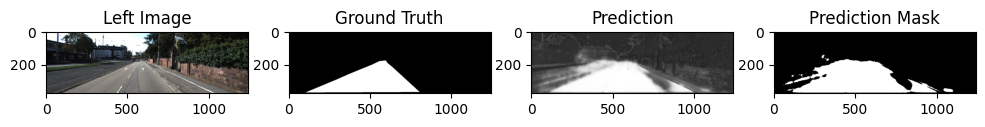

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
0.39802963 0.99997425 0.0076758466


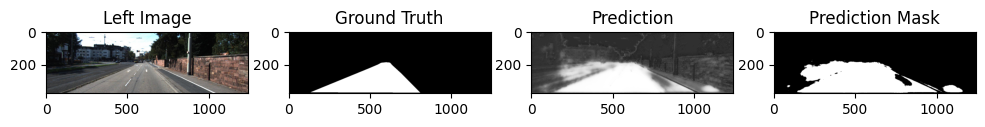

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
0.42916796 0.9999923 0.009768363


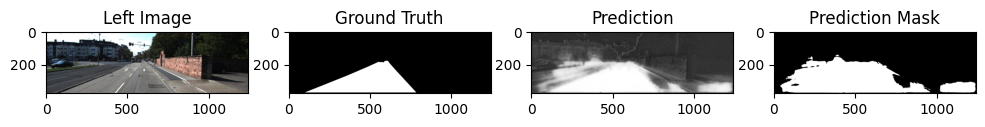

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
0.39123005 0.999998 0.015783172


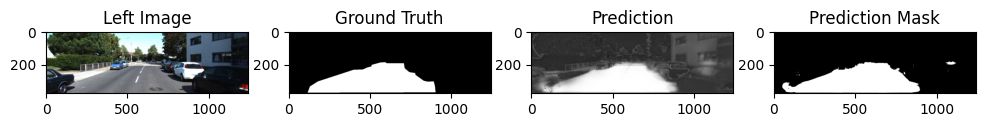

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
0.39550394 0.99989486 0.021802481


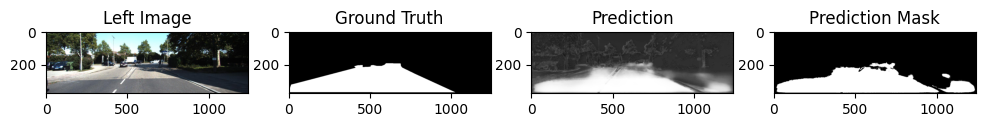

In [86]:
# Visualize predict
visualize = True
if visualize:
    for i in range(5):
        visualize_prediction('road_model_final_BEST.h5', images, image_index=i)

### 4. Fit a plane in 3D to the road pixels by using the depth of the pixels. Make sure your algorithm is robust to outliers.

In [87]:
from mpl_toolkits.mplot3d import Axes3D

In [88]:
def fit_plane_ransac(location, mask, num_iterations=1000, min_inliers=100, 
                     threshold_distance=0.1):
    """
    Fit a plane in 3D using RANSAC
    """
    best_inliers = -1

    # Convert location to 2D array for RANSAC
    location_2d = location.reshape(-1, 3)
    mask_1d = mask.ravel()

    for _ in range(num_iterations):
        # Randomly sample points (3 required for plane)
        random_indices = np.random.choice(np.flatnonzero(mask_1d), size=3, 
                                          replace=False)
        sample_points = location_2d[random_indices]

        # Fit a plane to the sample points
        v1 = sample_points[1] - sample_points[0]
        v2 = sample_points[2] - sample_points[0]
        normal = np.cross(v1, v2)
        normal /= np.linalg.norm(normal)
        dot_product = -np.dot(normal, sample_points[0])

        # Calculate distance from plane for all points
        distances = np.abs(np.dot(location_2d, normal) + dot_product)

        # Count inliers
        inliers = np.sum(distances < threshold_distance)

        # Check if this plane has more inliers than previous best
        if inliers > best_inliers:
            best_inliers = inliers

            if best_inliers > min_inliers:
                break

    # Refit plane using all inliers
    inlier_points = location_2d[distances < threshold_distance]
    v1 = inlier_points[1] - inlier_points[0]
    v2 = inlier_points[2] - inlier_points[0]
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)
    dot_product = -np.dot(normal, inlier_points[0])

    return (normal, dot_product), inlier_points

In [89]:
def visualize_plane(location, mask, plane_normal, plane_dot, inlier_points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot road points
    road_points = location[mask == 255]
    ax.scatter(road_points[:, 0], road_points[:, 1], road_points[:, 2], 
               c='blue', marker='o', label='Road Points')

    # Plot inlier points
    ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], 
               c='red', marker='x', label='Inlier Points')

    # Plot fitted plane
    x_range = np.linspace(np.min(location[:, 0]), np.max(location[:, 0]), 10)
    y_range = np.linspace(np.min(location[:, 1]), np.max(location[:, 1]), 10)
    xx, yy = np.meshgrid(x_range, y_range)

    print("xx shape:", xx.shape)
    print("yy shape:", yy.shape)
    print("plane_normal:", plane_normal)
    print("plane_d:", plane_dot)

    zz = (-plane_normal[0] * xx - plane_normal[1] * yy - plane_dot) / plane_normal[2]

    print("zz shape:", zz.shape)
    print("zz:", zz)

    ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Fitted Plane')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Plane Fitting')
    ax.legend()

    plt.show()

255


/usr/local/lib/python3.11/site-packages/numpy/core/numeric.py:1649: RuntimeWarning: invalid value encountered in subtract
  cp0 -= tmp
/usr/local/lib/python3.11/site-packages/numpy/core/numeric.py:1652: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/usr/local/lib/python3.11/site-packages/numpy/core/numeric.py:1655: RuntimeWarning: invalid value encountered in subtract
  cp2 -= tmp
/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_52805/633638183.py:20: RuntimeWarning: invalid value encountered in subtract
  v1 = sample_points[1] - sample_points[0]
/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_52805/633638183.py:21: RuntimeWarning: invalid value encountered in subtract
  v2 = sample_points[2] - sample_points[0]
/usr/local/lib/python3.11/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid v

xx shape: (10, 10)
yy shape: (10, 10)
plane_normal: [-0.85820749  0.         -0.51330294]
plane_d: 10709.493219947093
zz shape: (10, 10)
zz: [[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]


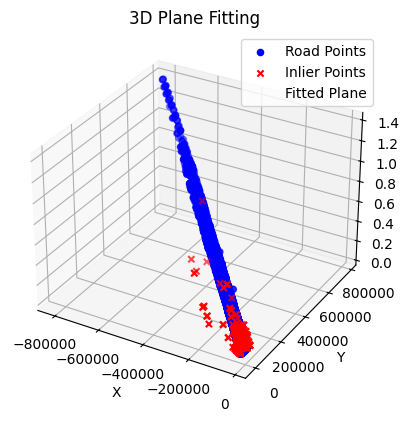

In [90]:
# Fit the plane in 3D
depth, mask = depth_maps[0], ground_truth_images[0]
print(np.max(mask))
location = compute_3D_location(depth)
plane, inliers = fit_plane_ransac(location, mask)
visualize_plane(location, mask, plane[0], plane[1], inliers)

### 5. Plot each pixel in 3D (we call this a 3D point cloud). On the same plot, show also the estimated ground plane.